# Pass maps for the 2012 CL final

Using event data of the 2012 Champions League final between Bayern Munich and Borussia Dortmund, pass maps for both teams and all players can be created in this notebook.

The data was sourced from Statsbomb.

In [45]:
# imports
import mplsoccer.statsbomb as sb
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt
import pandas as pd
import json
import requests
import ipywidgets as widgets

In [46]:
# team widget
team = widgets.Dropdown(
    options=['Borussia Dortmund', 'Bayern Munich'],
    value='Bayern Munich',
    description='Team:',
    disabled=False,
)

display(team)

Dropdown(description='Team:', index=1, options=('Borussia Dortmund', 'Bayern Munich'), value='Bayern Munich')

In [47]:
# reading the event data for the match
url = "https://raw.githubusercontent.com/sarahhouy/sports_analytics/main/data/events_cl_final_2012.json"

response = requests.get(url)
events = json.loads(response.content)
normalized = pd.json_normalize(events) 
df_events = pd.DataFrame(normalized)

In [48]:
# flatten the nested json file
df_events_flat = sb.flatten_event(events, 18240, dataframe=True)

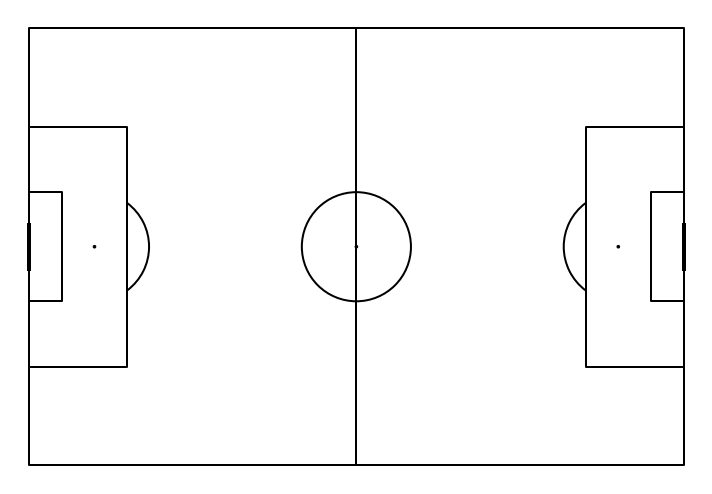

In [49]:
# draw pitch
pitch = Pitch(pitch_color="white", line_color = "black")
fig, ax = pitch.draw(figsize=(10, 7))

In [50]:
# create df that contains passes for selected team
df_passes = df_events.loc[(df_events["type.name"] == "Pass") & (df_events["team.name"] == team.value) & (df_events["pass.type.name"] != "Throw-in")]

### Pass map for only one player

In [51]:
# define list of players
all_players = [p for p in df_passes["player.name"].unique()]

In [52]:
# player widget
player = widgets.Dropdown(
    options=all_players,
    value='Arjen Robben',
    description='Player:',
    disabled=False,
)

display(player)

Dropdown(description='Player:', index=9, options=('Mario Mandžukić', 'Thomas Müller', 'Bastian Schweinsteiger'…

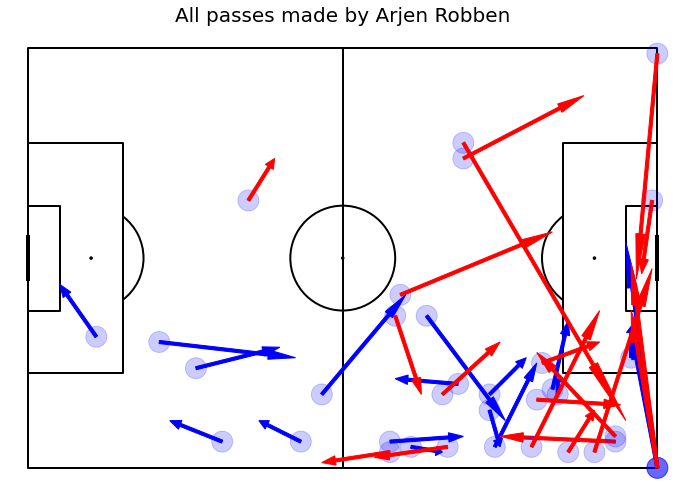

In [53]:
# create figure and axes objects
fig, ax = pitch.draw(figsize=(10, 7))

# create pass map for all passes
for i,thepass in df_passes.iterrows():
    if thepass['player.name']==player.value:
        x = thepass['location'][0]
        y = thepass['location'][1]
        #plot circle
        passCircle=plt.Circle((x,y),2,color="blue")      
        passCircle.set_alpha(.2)   
        ax.add_patch(passCircle)
        dx=thepass['pass.end_location'][0]-x
        dy=thepass['pass.end_location'][1]-y
        #plot arrow
        passArrow=plt.Arrow(x,y,dx,dy,width=3,color = {1: "blue", 2: "red"}.get(thepass["period"], "gray"))
        ax.add_patch(passArrow)

ax.set_title(f"All passes made by " + player.value, fontsize = 20)     
fig.set_size_inches(10, 7)
plt.show()

### Pass maps for all players of selected team

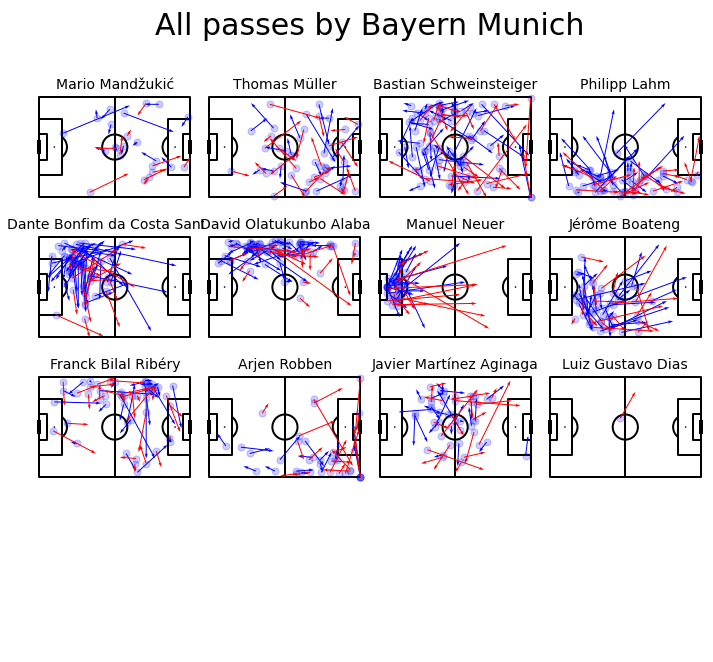

In [54]:
# get the list of all players who made a pass
names = df_passes['player.name'].unique()

# draw 4x4 pitches
pitch = Pitch(line_color='black', pad_top=20)
fig, axs = pitch.grid(ncols = 4, nrows = 4, grid_height=0.85, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0.04, endnote_space=0.01)

# draw pitch with passes for each player
for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    #put player name over the plot
    ax.text(60, -10, name,
            ha='center', va='center', fontsize=14)
    #take only passes by this player
    player_df = df_passes.loc[df_passes["player.name"] == name]
    #scatter
    pitch.scatter(player_df["location"].str[0], player_df["location"].str[1], alpha = 0.2, s = 50, color = "blue", ax=ax)
    #plot arrow
    pitch.arrows(player_df["location"].str[0], player_df["location"].str[1],
            player_df["pass.end_location"].str[0], player_df["pass.end_location"].str[1], color = player_df["period"].map({1: "blue", 2: "red"}).fillna("gray"), ax=ax, width=1)
    
# Remove pitches that are not needed
for ax in axs['pitch'][-1, 12 - len(names):]:
    ax.remove()
    
# Set title using mplsoccer 
axs['title'].text(0.5, 0.5, 'All passes by ' + team.value, ha='center', va='center', fontsize=30)
plt.show()

### Additional stats on passes

In [55]:
# count all passes
total_rows = len(df_passes.index)

# count passes made in first and second half
first_half = len(df_passes[df_passes['period'] == 1].index)
second_half = len(df_passes[df_passes['period'] == 2].index)

# count passes made to the box
# x-coordinate has to be greater or equal to 102 and y-coordinate has to be between 18 and 62
box_pass = len(df_passes[(df_passes['pass.end_location'].str[0]>=102) & (df_passes['pass.end_location'].str[1]>=18) & (df_passes['pass.end_location'].str[1]<=62)].index)
# count passes made to the box in the first half
box_pass_first = len(df_passes[(df_passes['pass.end_location'].str[0]>=102) & 
                         (df_passes['pass.end_location'].str[1]>=18) & 
                         (df_passes['pass.end_location'].str[1]<=62) &
                         (df_passes['period'] == 1)].index)
# count passes made to the box in the second half
box_pass_second = len(df_passes[(df_passes['pass.end_location'].str[0]>=102) & 
                         (df_passes['pass.end_location'].str[1]>=18) & 
                         (df_passes['pass.end_location'].str[1]<=62) &
                         (df_passes['period'] == 2)].index)

print('Total number of passes: ' + str(total_rows))
print('Number of passes in first half: ' + str(first_half))
print('Number of passes in second half: ' + str(second_half))
print('Number of passes made to the box: ' + str(box_pass))
print('Number of passes made to the box in the first half: ' + str(box_pass_first))
print('Number of passes made to the box in the second half: ' + str(box_pass_second))

Total number of passes: 560
Number of passes in first half: 326
Number of passes in second half: 234
Number of passes made to the box: 54
Number of passes made to the box in the first half: 22
Number of passes made to the box in the second half: 32


In [56]:
# number of passes by player
event_counts = df_passes['player.name'].value_counts()
print(event_counts)

Bastian Schweinsteiger          84
David Olatukunbo Alaba          65
Dante Bonfim da Costa Santos    62
Philipp Lahm                    57
Jérôme Boateng                  52
Franck Bilal Ribéry             52
Thomas Müller                   46
Javier Martínez Aginaga         46
Arjen Robben                    37
Manuel Neuer                    35
Mario Mandžukić                 23
Luiz Gustavo Dias                1
Name: player.name, dtype: int64


In [57]:
# number of passes to box by player
passes_per_player = df_passes.groupby('player.name').apply(lambda x: len(x[(x['pass.end_location'].str[0]>=102) & (x['pass.end_location'].str[1]>=18) & (x['pass.end_location'].str[1]<=62)]))

print(passes_per_player)

player.name
Arjen Robben                    11
Bastian Schweinsteiger           8
Dante Bonfim da Costa Santos     2
David Olatukunbo Alaba           3
Franck Bilal Ribéry              7
Javier Martínez Aginaga          3
Jérôme Boateng                   2
Luiz Gustavo Dias                0
Manuel Neuer                     0
Mario Mandžukić                  5
Philipp Lahm                     5
Thomas Müller                    8
dtype: int64
